<a href="https://www.kaggle.com/code/abhijitdarekar001/flan-t5-base-xgbregressor?scriptVersionId=152902100" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# !pip install -q transformers
import pandas as pd
import numpy as np
pd.set_option('max_colwidth',None)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch import nn
import torch

from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class CONFIG():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    BASE_PATH = '/kaggle/input/commonlit-evaluate-student-summaries/'
    MODEL_NAME='/kaggle/input/flan-t5/pytorch/base/4'
    MAX_LENGTH= 2048
    
config= CONFIG()

In [3]:
train_df = pd.read_csv(f"{config.BASE_PATH}prompts_train.csv")
test_df = pd.read_csv(f"{config.BASE_PATH}prompts_test.csv")

In [4]:
print('Displaying Train Prompts')
print("-"*100)
train_df.head(2)

Displaying Train Prompts
----------------------------------------------------------------------------------------------------


,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,"Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.",On Tragedy,"Chapter 13 \r\nAs the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. \r\nA perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, again, should the downfall of the utter villain be exhibited. A plot of this kind would, doubtless, satisfy the moral sense, but it would inspire neither pity nor fear; for pity is aroused by unmerited misfortune, fear by the misfortune of a man like ourselves. Such an event, therefore, will be neither pitiful nor terrible. There remains, then, the character between these two extremes — that of a man who is not eminently good and just, yet whose misfortune is brought about not by vice or depravity, but by some error of judgement or frailty. He must be one who is highly renowned and prosperous — a personage like Oedipus, Thyestes, or other illustrious men of such families. \r\nA well-constructed plot should, therefore, be single in its issue, rather than double as some maintain. The change of fortune should be not from bad to good, but, reversely, from good to bad. It should come about as the result not of vice, but of some great error or frailty, in a character either such as we have described, or better rather than worse. The practice of the stage bears out our view. At first the poets recounted any legend that came in their way. Now, the best tragedies are founded on the story of a few houses — on the fortunes of Alcmaeon, Oedipus, Orestes, Meleager, Thyestes, Telephus, and those others who have done or suffered something terrible. A tragedy, then, to be perfect according to the rules of art, should be of this construction. Hence they are in error who censure Euripides just because he follows this principle in his plays, many of which end unhappily. It is, as we have said, the right ending. The best proof is that on the stage and in dramatic competition, such plays, if well worked out, are the most tragic in effect; and Euripides, faulty though he may be in the general management of his subject, yet is felt to be the most tragic of the poets. \r\nIn the second rank comes the kind of tragedy which some place first. Like the Odyssey, it has a double thread of plot, and also an opposite catastrophe for the good and for the bad. It is accounted the best because of the weakness of the spectators; for the poet is guided in what he writes by the wishes of his audience. The pleasure, however, thence derived is not the true tragic pleasure. It is proper rather to Comedy, where those who, in the piece, are the deadliest enemies — like Orestes and Aegisthus — quit the stage as friends at the close, and no one slays or is slain."
1,3b9047,"In complete sentences, summarize the structure of the ancient Egyptian system of government. How were different social classes involved in this government? Cite evidence from the text.",Egyptian Social Structure,"Egyptian society was structured like a pyramid. At the top were the gods, such as Ra, Osiris, and Isis. Egyptians believed that the gods controlled the universe. Therefore, it was important to keep them happy. They could make the Nile overflow, cause

In [5]:
print('Displaying Test Prompts')
print("-"*100)
test_df.head(2)

Displaying Test Prompts
----------------------------------------------------------------------------------------------------


,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


In [6]:
train_summaries_df = pd.read_csv(f"{config.BASE_PATH}summaries_train.csv")
test_summaries_df = pd.read_csv(f"{config.BASE_PATH}summaries_test.csv")

In [7]:
print('Displaying Train Summaries')
print("-"*100)
train_summaries_df.head(2)

Displaying Train Summaries
----------------------------------------------------------------------------------------------------


,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the smell go away and it wouldnt be a bad smell. Some of the meat would be tossed on the floor where there was sawdust spit of the workers and they would make the meat all over again with the things in it.,-0.548304,0.506755


In [8]:
print('Displaying Test Summaries')
print("-"*100)
test_summaries_df.head(2)

Displaying Test Summaries
----------------------------------------------------------------------------------------------------


,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2


In [9]:
print("Displaying Sample Submission File")
final_submission = pd.read_csv(f"{config.BASE_PATH}sample_submission.csv")
print("-"*100)
final_submission.head(2)

Displaying Sample Submission File
----------------------------------------------------------------------------------------------------


,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0


In [10]:
# Preprocess function
def pre_process(prompt_df, summaries_df, mode='train'):
    
    # Defining Tokenizer and Pre-Processing 
    tokenizer = T5Tokenizer.from_pretrained(config.MODEL_NAME)
    t5_model = T5ForConditionalGeneration.from_pretrained(config.MODEL_NAME).to(config.device)  
    # Merging Dataframe
    df = prompt_df.merge(summaries_df, on ='prompt_id')
    df['infomation_text'] = 'prompt '+df['prompt_question']+ ' prompt_title '+df['prompt_title']+' prompt_text '+df['prompt_text']+' text '+df['text']
    
    #Generating Vectors/Embeddings 
    tokenized_inputs = tokenizer(list(df['infomation_text'].values), padding = 'max_length', max_length=config.MAX_LENGTH)
    
    if mode=='train':
        input_ids=tokenized_inputs['input_ids']
        target = df[['content','wording']].values
        return input_ids, target
    
    if mode=='test':
        input_ids=tokenized_inputs['input_ids']
        return input_ids

In [11]:
input_ids , targets = pre_process(train_df,train_summaries_df , mode='train')

#### Training

In [12]:
X_train, X_test, y_train, y_test  = train_test_split(input_ids, targets,test_size=0.2, random_state=101)

#### XGB Regressor

In [13]:
regressor=XGBRegressor()
regressor.fit(X_train,y_train)
pred=regressor.predict(X_test)
print(f'Mean Square Error :{mean_squared_error(y_pred=pred, y_true=y_test, multioutput="raw_values")}')

Mean Square Error :[0.28627682 0.61202492]


#### Testing

In [14]:
tokenized_test_inptus = pre_process(test_df, test_summaries_df, 'test')
outputs = regressor.predict(tokenized_test_inptus)

In [15]:
# Submission
content = [k[0] for k in outputs]
wording = [k[1] for k in outputs]
final_submission['content'] = content
final_submission['wording'] = wording
final_submission

,student_id,content,wording
0,000000ffffff,-1.767422,-1.078934
1,111111eeeeee,-1.767422,-1.078934
2,222222cccccc,-1.767422,-1.078934
3,333333dddddd,-1.767422,-1.078934


#### Other Regressor's (RandomForesetRegressor and GradientBoostingRegressor)

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import RandomizedSearchCV

In [17]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr_Pred = rfr.predict(X_test)

print(f"MSE for RandomForestRegressor :", mean_squared_error(y_test, rfr_Pred, multioutput='raw_values'))

MSE for RandomForestRegressor : [0.26978354 0.55889604]


#### GradinetBoostingRegressor with MultiOutputRegressor

In [18]:
gbr = MultiOutputRegressor(GradientBoostingRegressor())
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)

In [19]:
print(f"MSE for GradientBoosting Regressor :", mean_squared_error(y_test, gbr_pred, multioutput='raw_values'))

MSE for GradientBoosting Regressor : [0.28325271 0.60645899]


#### Preprocessing with TFIDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
# nltk.download('punkt')
# nltk.download('stopwords')

In [21]:
vectorizer = TfidfVectorizer()
raw_df = train_df.merge(train_summaries_df ,on ='prompt_id')

In [22]:
import string
def get_words_count_after_stopwords_removal(text):
    """
    Function to check if the wording and content points depends upon less stop words.
    """
    new_text = ''
    for char in text :
        if char in string.punctuation:
            pass 
        else:
            new_text+=char
    new_text=new_text.split()
    stop_words = set(stopwords.words('english'))
    text = [word for word in new_text if word not in stop_words]
    return len(text)


def get_words_count_(text):
    """
    Function to check numbers of words is realted to the wording and content.
    """
    new_text = ''
    for char in text :
        if char in string.punctuation:
            pass 
        else:
            new_text+=char
    new_text=new_text.split()
    return len(new_text)

def get_words_count_(text):
    """
    Function to check numbers of words is realted to the wording and content.
    """
    new_text = ''
    for char in text :
        if char in string.punctuation:
            pass 
        else:
            new_text+=char
    new_text=new_text.split()
    return len(new_text)

def get_stop_words_count(text):
    """
    Function to check numbers of words is realted to the wording and content.
    """
   
    new_text = ''
    for char in text :
        if char in string.punctuation:
            pass 
        else:
            new_text+=char

    return len(new_text)

In [23]:
# counting the total number of words other then stop words.
raw_df['prompt_question_wrds_count_Witht_stopwords'] = raw_df['prompt_question'].apply(get_words_count_after_stopwords_removal)
raw_df['prompt_title_wrds_count_Witht_stopwords'] = raw_df['prompt_title'].apply(get_words_count_after_stopwords_removal)
raw_df['prompt_text_wrds_count_Witht_stopwords'] = raw_df['prompt_text'].apply(get_words_count_after_stopwords_removal)
raw_df['text_wrds_count_Witht_stopwords'] = raw_df['text'].apply(get_words_count_after_stopwords_removal)

In [24]:
# counting the total number of words.

raw_df['prompt_question_total_words'] = raw_df['prompt_question'].apply(get_words_count_)
raw_df['prompt_title_total_words'] = raw_df['prompt_title'].apply(get_words_count_)
raw_df['prompt_text_total_words'] = raw_df['prompt_text'].apply(get_words_count_)
raw_df['text_total_words'] = raw_df['text'].apply(get_words_count_)

In [25]:
# counting the total number of stop words

raw_df['prompt_question_total_stopwords'] = raw_df['prompt_question'].apply(get_stop_words_count)
raw_df['prompt_title_total_stopwords'] = raw_df['prompt_title'].apply(get_stop_words_count)
raw_df['prompt_text_total_stopwords'] = raw_df['prompt_text'].apply(get_stop_words_count)
raw_df['text_total_stopwords'] = raw_df['text'].apply(get_stop_words_count)

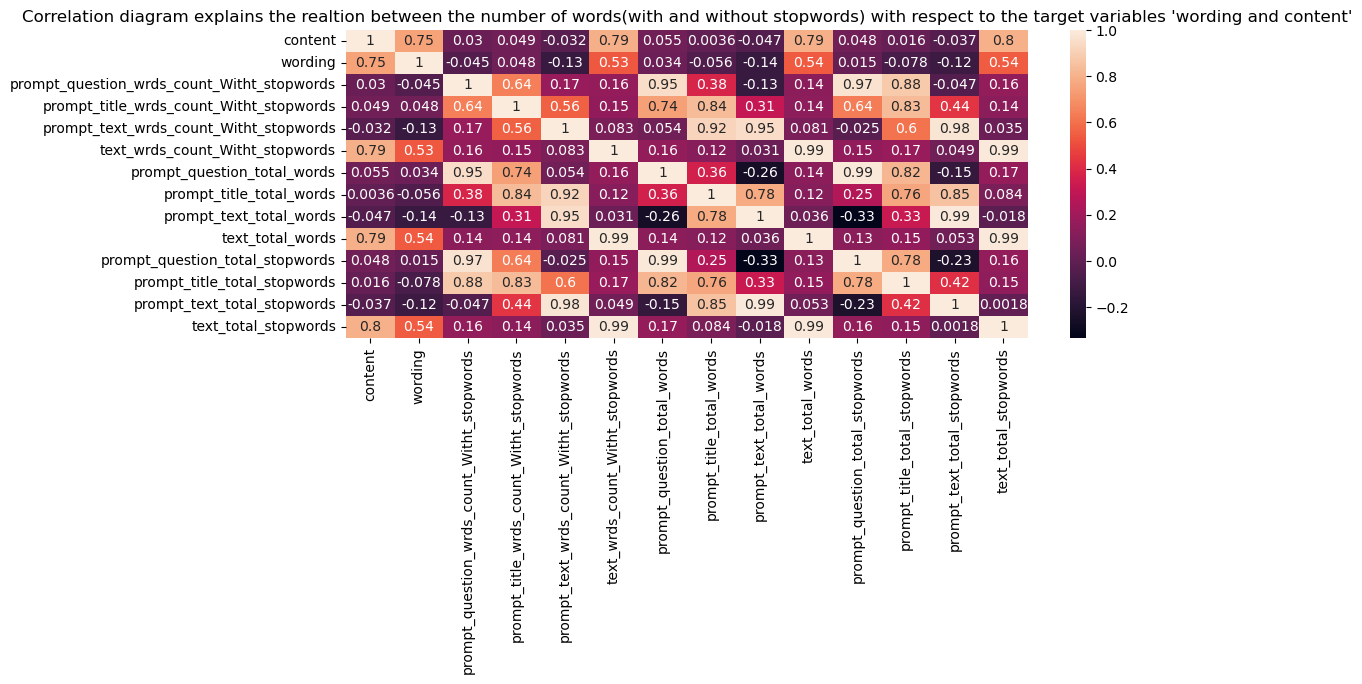

In [26]:
# Correlation diagram explains the realtion between the number of words(with and without stopwords) with respect to the target variables 'wording and content'
plt.figure(figsize=(11,4))

plt.title("Correlation diagram explains the realtion between the number of words(with and without stopwords) with respect to the target variables 'wording and content'")
sns.heatmap(raw_df.corr(), annot= True)
plt.show()

From the below heatmap we get the following.
1. Total words count excluding stop words is related to content and wording. the more words with respect to prompt the more points in content and wording.
2. Same with total words and total stopwords count. these are co-related with wording and content as well.
3. Count of total stop words is highly co-related to count of total words aswell.
4. The total number of prompt text is co-realted to the good explaination in prompt title.


Keep these points in picture, lets build the model with length of each text.

In [27]:
del raw_df
df = train_df.merge(train_summaries_df ,on ='prompt_id')


df['prompt_question_wrds_count_Witht_stopwords'] = df['prompt_question'].apply(get_words_count_after_stopwords_removal)
df['prompt_title_wrds_count_Witht_stopwords'] = df['prompt_title'].apply(get_words_count_after_stopwords_removal)
df['prompt_text_wrds_count_Witht_stopwords'] = df['prompt_text'].apply(get_words_count_after_stopwords_removal)
df['text_wrds_count_Witht_stopwords'] = df['text'].apply(get_words_count_after_stopwords_removal)


df['prompt_question_total_words'] = df['prompt_question'].apply(get_words_count_)
df['prompt_title_total_words'] = df['prompt_title'].apply(get_words_count_)
df['prompt_text_total_words'] = df['prompt_text'].apply(get_words_count_)
df['text_total_words'] = df['text'].apply(get_words_count_)

In [28]:
train = df.select_dtypes(include='int64')
test = df.select_dtypes(include = 'float64')

In [29]:
X_train_1,X_test_2 , y_train_2, y_test_2 = train_test_split(train, test , test_size=0.2, random_state=42)

In [30]:
rfr2 = RandomForestRegressor()
rfr2.fit(X_train_1, y_train_2)
y_pred_2 = rfr2.predict(X_test_2)

print(f"MSE for RandomForesetRegressor with {mean_squared_error(y_pred_2 , y_test_2, multioutput='raw_values')}")

MSE for RandomForesetRegressor with [0.31199284 0.70006987]


In [31]:
df_test_2 = test_df.merge(test_summaries_df, on='prompt_id')

df_test_2['prompt_question_wrds_count_Witht_stopwords'] = df_test_2['prompt_question'].apply(get_words_count_after_stopwords_removal)
df_test_2['prompt_title_wrds_count_Witht_stopwords'] = df_test_2['prompt_title'].apply(get_words_count_after_stopwords_removal)
df_test_2['prompt_text_wrds_count_Witht_stopwords'] = df_test_2['prompt_text'].apply(get_words_count_after_stopwords_removal)
df_test_2['text_wrds_count_Witht_stopwords'] = df_test_2['text'].apply(get_words_count_after_stopwords_removal)


df_test_2['prompt_question_total_words'] = df_test_2['prompt_question'].apply(get_words_count_)
df_test_2['prompt_title_total_words'] = df_test_2['prompt_title'].apply(get_words_count_)
df_test_2['prompt_text_total_words'] = df_test_2['prompt_text'].apply(get_words_count_)
df_test_2['text_total_words'] = df_test_2['text'].apply(get_words_count_)

In [32]:
rfr2.predict(df_test_2.select_dtypes(include= 'int64'))

array([[-1.30927076, -1.42748105],
       [-1.30927076, -1.42748105],
       [-1.30927076, -1.42748105],
       [-1.30927076, -1.42748105]])